From: Suryanarayanan Balaji

# Speeding up molecular analysis using Support Vector Machines

 Machine Learning plays a pivotal role across diverse applications, with a significant impact seen in the field of cheminformatics [Niazi and Marium, 2023](https://www.mdpi.com/1422-0067/24/14/11488#:~:text=3.-,Fundamentals%20of%20Chemoinformatics,a%20complex%2C%20multilayer%20computational%20process.). Chemical compounds can be represented using SMILES, a string-based representation known for its simplicity and adaptability. Molecular
 fingerprints, derived from SMILES, are vectors containing essential information such as valency, atom types, and other structural
 features. By leveraging these vectors, molecular fingerprints serve as compact and informative representations, facilitating the
 application of computational methods, such as machine learning, in tasks like virtual screening, quantitative structure-activity relationship
 (QSAR) modeling, and molecular property prediction [Balaji et al., 2023](https://arxiv.org/pdf/2310.03030.pdf).
 
 MoleculeNet is a widely recognized benchmark dataset and framework for evaluating machine learning models in the field of molecular informatics and drug discovery. It was introduced to address the need for standardized datasets and evaluation metrics in the development of predictive models for various molecular properties. MoleculeNet covers a diverse range of tasks relevant to drug discovery, such as toxicity prediction, molecular property prediction, and bioactivity prediction [MoleculeNet](https://arxiv.org/pdf/1703.00564.pdf).

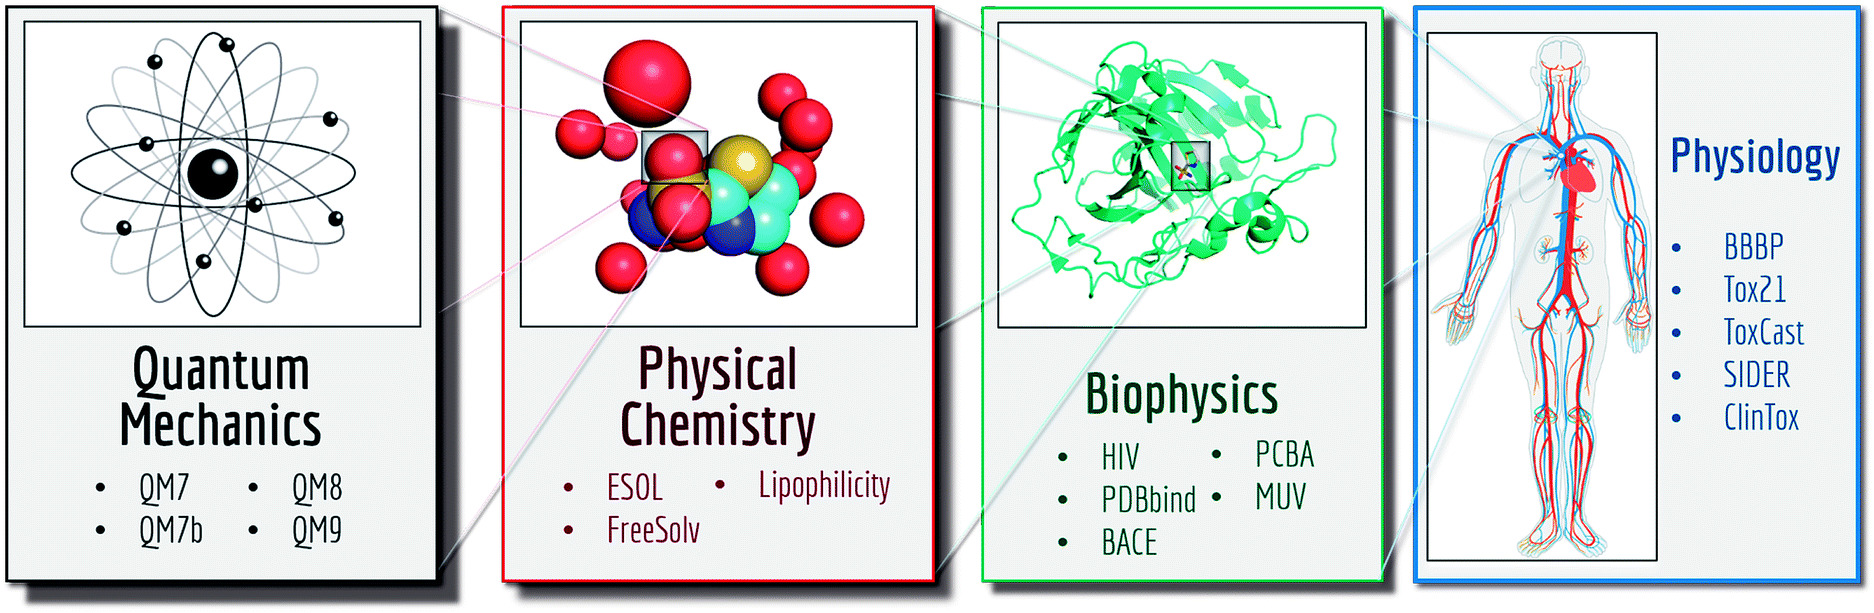

[MoleculeNet](https://arxiv.org/pdf/1703.00564.pdf)

The project utilizes the Quantum Mechanics 8 (QM8) dataset, one of the datasets under MoleculeNet. This dataset encompasses quantum mechanical properties of more than 20,000 synthetically viable small organic molecules, each featuring up to 8 configuration (CONF) atoms. Notably, the quantum mechanical properties involve electronic spectral data derived from discrepancies between time-dependent DFT calculations and second-order coupled-cluster (CC2) spectra. The project employs machine learning techniques to analyze and derive insights from this dataset.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Dataset Preparation

## Data Loading

This dataset comprises of 21786 molecules represented with SMILES and 12 labels. Molecular fingerprints were generated from the SMILES through the Extended-Connectivity Fingerprint method, which was used as the input to the machine learning model. Firsty, the dataset was loaded into JupyterHub.

In [4]:
file_path = os.path.join(os.getcwd(), 'qm8.csv')
df_original = pd.read_csv(file_path)
display(df_original)

,smiles,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,[H]C([H])([H])[H],0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,1.815015e-01,0.409931,0.409939,0.1832,0.1832
1,[H]N([H])[H],0.265220,0.350081,0.067015,0.030049,0.268386,0.349106,0.040761,3.164115e-02,0.253853,0.334481,0.0575,0.0238
2,[H]O[H],0.286537,0.363579,0.037755,0.000000,0.291377,0.362091,0.019503,1.000000e-08,0.278519,0.350074,0.0333,0.0000
3,[H]C#C[H],0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000e+00,0.244879,0.255051,0.0000,0.0000
4,[H]C#N,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000e+00,0.283425,0.296993,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,[H]C([H])(N1C([H])([H])C1([H])[H])C(F)(F)F,0.271951,0.297488,0.049481,0.039746,0.279686,0.305949,0.045505,3.645832e-02,0.276414,0.297798,0.0314,0.0409
21782,[H]C1([H])C([H])([H])C([H])(C(F)(F)F)C1([H])[H],0.343606,0.344621,0.044959,0.017041,0.347063,0.348212,0.003887,5.704017e-02,0.336025,0.337881,0.0376,0.0107
21783,[H]N1C([H])([H])C([H])([H])C1([H])C(F)(F)F,0.256356,0.279425,0.005103,0.010683,0.264920,0.280065,0.002531,9.899310e-03,0.253210,0.279390,0.0037,0.0086
21784,[H]C1([H])OC([H])(C(F)(F)F)C1([H])[H],0.271197,0.292573,0.000831,0.019204,0.279916,0.302611,0.000742,2.232390e-02,0.274602,0.299852,0.0004,0.0195


Here, the dataset is observed to consist of a column containing molecular SMILES and an additional 12 columns representing various labels. These labels include the first ($E_1$) and second ($E_2$) low-lying singlet transition energies, along with their corresponding oscillator strengths ($f_1$ and $f_2$). These values are derived by comparing Time-Dependent Density Functional Theory (TF-DFT) predictions with those obtained using three distinct models: second-order approximate coupled-cluster singles and doubles spectra (CC2), Perdew-Burke-Ernzerhof hybrid (PBE0), and Coulomb-Attenuating Method (CAM) [Ramakrishnan et al., 2015](https://pubs.aip.org/aip/jcp/article/143/8/084111/73278/Electronic-spectra-from-TDDFT-and-machine-learning).

## SMILES Canonicity

Before moving on, it is important to check for the authenticity of the molecules. SMILES, being non-canonical, allows a single SMILES string to represent multiple molecules. For this purpose, I verified if each SMILES has a corresponding molecule. Subsequently, I created a new column in the QM8 dataframe, where authentic SMILES were retained, and non-corresponding ones were replaced with an 'NA' string.  I then filtered the non-NA values out before dropping the new column. The code was adapted from my previous work in molecular property prediction [Balaji et al., 2023](https://arxiv.org/pdf/2310.03030.pdf).

In [6]:
def canonical (dataframe): 
    lst = []
    for i in dataframe['smiles']:
        mol = Chem.MolFromSmiles(i)
        if mol != None: 
            lst.append(Chem.MolToSmiles(mol))
        else:
            lst.append('Na')
    x = pd.DataFrame(lst, columns = ['canonical'])
    df = pd.concat([dataframe, x], axis = 1)
    df = df[df['canonical'] != 'Na'].drop(columns = 'canonical', axis = 1).reset_index(drop = True)
    return df

data = canonical(df_original)
display(data)

,smiles,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,[H]C([H])([H])[H],0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,1.815015e-01,0.409931,0.409939,0.1832,0.1832
1,[H]N([H])[H],0.265220,0.350081,0.067015,0.030049,0.268386,0.349106,0.040761,3.164115e-02,0.253853,0.334481,0.0575,0.0238
2,[H]O[H],0.286537,0.363579,0.037755,0.000000,0.291377,0.362091,0.019503,1.000000e-08,0.278519,0.350074,0.0333,0.0000
3,[H]C#C[H],0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000e+00,0.244879,0.255051,0.0000,0.0000
4,[H]C#N,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000e+00,0.283425,0.296993,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,[H]C([H])(N1C([H])([H])C1([H])[H])C(F)(F)F,0.271951,0.297488,0.049481,0.039746,0.279686,0.305949,0.045505,3.645832e-02,0.276414,0.297798,0.0314,0.0409
21782,[H]C1([H])C([H])([H])C([H])(C(F)(F)F)C1([H])[H],0.343606,0.344621,0.044959,0.017041,0.347063,0.348212,0.003887,5.704017e-02,0.336025,0.337881,0.0376,0.0107
21783,[H]N1C([H])([H])C([H])([H])C1([H])C(F)(F)F,0.256356,0.279425,0.005103,0.010683,0.264920,0.280065,0.002531,9.899310e-03,0.253210,0.279390,0.0037,0.0086
21784,[H]C1([H])OC([H])(C(F)(F)F)C1([H])[H],0.271197,0.292573,0.000831,0.019204,0.279916,0.302611,0.000742,2.232390e-02,0.274602,0.299852,0.0004,0.0195


From the above code, it is inferred that all the SMILES present in this dataset are canonical and correspond to a unique molecule. Although this may be considered a redundant step in this specific dataset, for other datasets it remains crucial to verify the canonicity of SMILES before generating descriptors.

## Generating Molecular Descriptors

Now that the SMILES have been verified, the subsequent step involves generating comprehensive molecular descriptions for each validated SMILES representation. Each SMILES is converted to a RDKit molecule object, from which its corresponding properties are extracted from the database. There are 209 possible properties for each molecule [Fabian et al., 2020](https://arxiv.org/pdf/2011.13230.pdf), covering a wide range, including but not limited to the Number of Aromatic Rings and Maximum Electron State Index.  These can be generated through RDKit's Molecular Descriptors module, which is then displayed as a dataframe below.

In [7]:
def descriptor (dataframe):
    l = []
    for x in dataframe['smiles']:
        mol = Chem.MolFromSmiles(x)
        full = Chem.AddHs(mol)
        descriptions =  Descriptors.CalcMolDescriptors(full)
        l.append(descriptions)
    df = pd.DataFrame(l)
    return df
    
df_x = descriptor(data)
display(df_x)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.937500,5.937500,2.500000,-2.500000,0.359785,16.043,12.011,16.031300,8,0,...,0,0,0,0,0,0,0,0,0,0
1,5.750000,5.750000,0.250000,-0.250000,0.397555,17.031,14.007,17.026549,8,0,...,0,0,0,0,0,0,0,0,0,0
2,5.375000,5.375000,2.750000,2.750000,0.327748,18.015,15.999,18.010565,8,0,...,0,0,0,0,0,0,0,0,0,0
3,5.902778,5.902778,1.597222,1.597222,0.332926,26.038,24.022,26.015650,10,0,...,0,0,0,1,0,0,0,0,0,0
4,6.986111,6.986111,1.000000,1.000000,0.369797,27.026,26.018,27.010899,10,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,12.060833,12.060833,0.479167,-5.329167,0.469607,125.093,119.045,125.045234,48,0,...,0,0,0,0,0,0,0,0,0,0
21782,12.385417,12.385417,3.336042,-5.466667,0.464608,124.105,117.049,124.049985,48,0,...,0,0,0,0,0,0,0,0,0,0
21783,12.218542,12.218542,0.708333,-5.315625,0.507034,125.093,119.045,125.045234,48,0,...,0,0,0,0,0,0,0,0,0,0
21784,12.004792,12.004792,3.065208,-5.247917,0.475485,126.077,121.037,126.029249,48,0,...,0,0,0,0,0,0,0,0,0,0


The labels were separated into the dataframe below.

In [8]:
df_y = data.iloc[:,1:]
display(df_y)

,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,1.815015e-01,0.409931,0.409939,0.1832,0.1832
1,0.265220,0.350081,0.067015,0.030049,0.268386,0.349106,0.040761,3.164115e-02,0.253853,0.334481,0.0575,0.0238
2,0.286537,0.363579,0.037755,0.000000,0.291377,0.362091,0.019503,1.000000e-08,0.278519,0.350074,0.0333,0.0000
3,0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000e+00,0.244879,0.255051,0.0000,0.0000
4,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000e+00,0.283425,0.296993,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
21781,0.271951,0.297488,0.049481,0.039746,0.279686,0.305949,0.045505,3.645832e-02,0.276414,0.297798,0.0314,0.0409
21782,0.343606,0.344621,0.044959,0.017041,0.347063,0.348212,0.003887,5.704017e-02,0.336025,0.337881,0.0376,0.0107
21783,0.256356,0.279425,0.005103,0.010683,0.264920,0.280065,0.002531,9.899310e-03,0.253210,0.279390,0.0037,0.0086
21784,0.271197,0.292573,0.000831,0.019204,0.279916,0.302611,0.000742,2.232390e-02,0.274602,0.299852,0.0004,0.0195


## Data Standardization

In the given DataFrame, we observe 209 diverse molecular properties, ranging from minimal values, such as the number of urea fragments (fr_urea), to more substantial values, exemplified by columns like molecular weight (MolWt) exceeding 100. To address potential biases arising from disparate scales and to ensure that machine learning models appropriately consider all properties, the dataset has undergone scaling on a column-wise basis. The StandardScaler model from sklearn was used here, which transforms the data into a normal distribution with mean of 0 and standard deviation of 1. This is displayed below.

In [9]:
scaler = StandardScaler()
df_x_scaled = pd.DataFrame(scaler.fit_transform(df_x), columns = df_x.columns)
display(df_x_scaled)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.807333,-1.807333,1.344524,0.532406,-1.319668,-11.514119,-11.231206,-11.511977,-9.647487,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
1,-1.921130,-1.921130,-0.873131,3.509093,-0.766442,-11.391562,-10.977814,-11.388465,-9.647487,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
2,-2.148723,-2.148723,1.590931,7.478008,-1.788922,-11.269501,-10.724930,-11.266347,-9.647487,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
3,-1.828407,-1.828407,0.454724,5.952916,-1.713070,-10.274283,-9.706411,-10.272899,-9.095687,0.0,...,0.0,0.0,0.0,2.758363,-0.059943,0.0,0.0,0.0,0.0,-0.096055
4,-1.170915,-1.170915,-0.133913,5.162808,-1.173019,-10.151726,-9.453019,-10.149387,-9.095687,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,1.909011,1.909011,-0.647259,-3.210502,0.288909,2.013054,2.356752,2.016874,1.388517,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
21782,2.106006,2.106006,2.168548,-3.392410,0.215692,1.890497,2.103360,1.893362,1.388517,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
21783,2.004727,2.004727,-0.421386,-3.192586,0.837121,2.013054,2.356752,2.016874,1.388517,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055
21784,1.874999,1.874999,1.901608,-3.103010,0.375004,2.135115,2.609636,2.138993,1.388517,0.0,...,0.0,0.0,0.0,-0.322417,-0.059943,0.0,0.0,0.0,0.0,-0.096055


## Principal Component Analysis

Now that the data is properly scaled, there is less risk of any model performing poorly due to incorrect variable importance and convergence issues. However, there are 209 properties, out of which many of them may not contribute positively to the performance of the model. Additionally, the presence of the extra properties increases the computation time of the model. To account for this, principal component analysis (PCA) is conducted as a form of dimensionality reduction method, which will extract the relevant input features which preserving the most important patterns or relationships between the features without prior knowledge of the variables. The PCA module in sklearn is used for this purpose.

In [10]:
n_com = 70
pca = PCA(n_components = n_com)
df_x_pca = pd.DataFrame(pca.fit_transform(df_x_scaled), columns = [f'component_{x+1}' for x in range(n_com)])
display(df_x_pca)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70
0,5.422019,-1.393346,13.266361,17.861929,14.198995,21.410747,-0.024813,5.291344,-0.933015,-2.298932,...,3.904986,-0.991981,1.862571,2.967464,0.961460,-0.751658,1.337947,-0.804344,0.048684,-1.113154
1,9.374021,4.906049,9.654574,15.197851,14.881054,24.499612,-1.435542,7.558944,1.188192,-3.369884,...,-0.028095,-2.060213,5.537235,9.055971,-2.575572,5.281524,1.226415,-0.443087,-1.039402,-0.622297
2,10.172213,5.528628,9.689506,16.398643,16.090855,22.661743,1.265243,7.540092,1.740296,-3.829621,...,-1.259457,-1.832647,4.109393,8.746102,-3.783771,4.620716,1.062939,-0.464021,-0.741863,-0.257440
3,9.830465,2.787265,15.012905,18.649968,11.300852,14.333539,0.079719,2.964232,2.252977,-1.111759,...,-0.541838,-0.050686,0.398781,1.261512,-0.109377,0.258524,0.853064,1.250901,-0.064026,-0.284956
4,12.996386,3.242484,13.333088,17.298744,11.700945,12.873008,0.850233,6.142462,-2.831243,-1.004740,...,-0.081375,-0.067154,-0.248231,0.844383,-2.622156,-1.447949,2.116390,0.065457,0.967035,-1.369522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,2.615890,-1.498775,-2.128677,1.784871,-2.736303,-4.102645,4.669474,3.331067,-4.536531,6.494771,...,0.314197,1.042026,0.582900,0.858161,0.886876,-1.234991,0.000327,-0.646479,0.272838,0.509199
21782,-1.342530,-1.533144,0.140333,2.996040,-4.851216,-4.628742,4.963769,7.159419,-2.513171,5.237163,...,0.252199,0.572655,0.634949,0.351898,1.215270,-0.146389,0.444436,-0.689464,0.174927,0.734801
21783,2.585728,-1.066882,-2.758877,0.951525,-3.298904,-3.472460,3.102636,4.606340,-2.702175,5.845364,...,0.066359,-0.245964,0.033505,0.331664,1.144454,0.052447,-0.604086,-0.572088,0.015686,-0.087068
21784,2.752418,-1.675327,-2.825271,2.155355,-1.874370,-5.156593,6.414746,5.175410,-2.212541,5.705970,...,0.437354,0.835999,0.431378,0.257020,0.664566,0.059083,-0.016718,-0.216935,0.160490,-0.246714


In [11]:
print(f'{len(df_x_pca.columns)} components captures {100*sum(pca.explained_variance_ratio_):1.2f}% of the original dataset.')

70 components captures 96.55% of the original dataset.


From the analysis above, it is seen that using 70 components is enough to capture over 96% of the variability of the original dataset. Using this smaller dataset for machine learning analysis will not only improve computational efficiency but also reduce the risk of overfitting. 

## Outlier Analysis

With the number of columns reduced, it is time to check for outliers. Outliers can introduce noise and skew the models resulting in incorrect conclusions. They can distort the relationships between variables, affect the mean and standard deviation, and influence the performance of algorithms that are sensitive to the scale and distribution of data. 

Firstly, we check the number of outliers present in each column. This is done using a boxplot, which will display the mean, 25th and 75th percentile of each column. Moreover, it assists in the visualization of data points that fall outside the typical range, providing an initial idea of the number of outliers in that particular column. The boxplot visualization is displayed below.

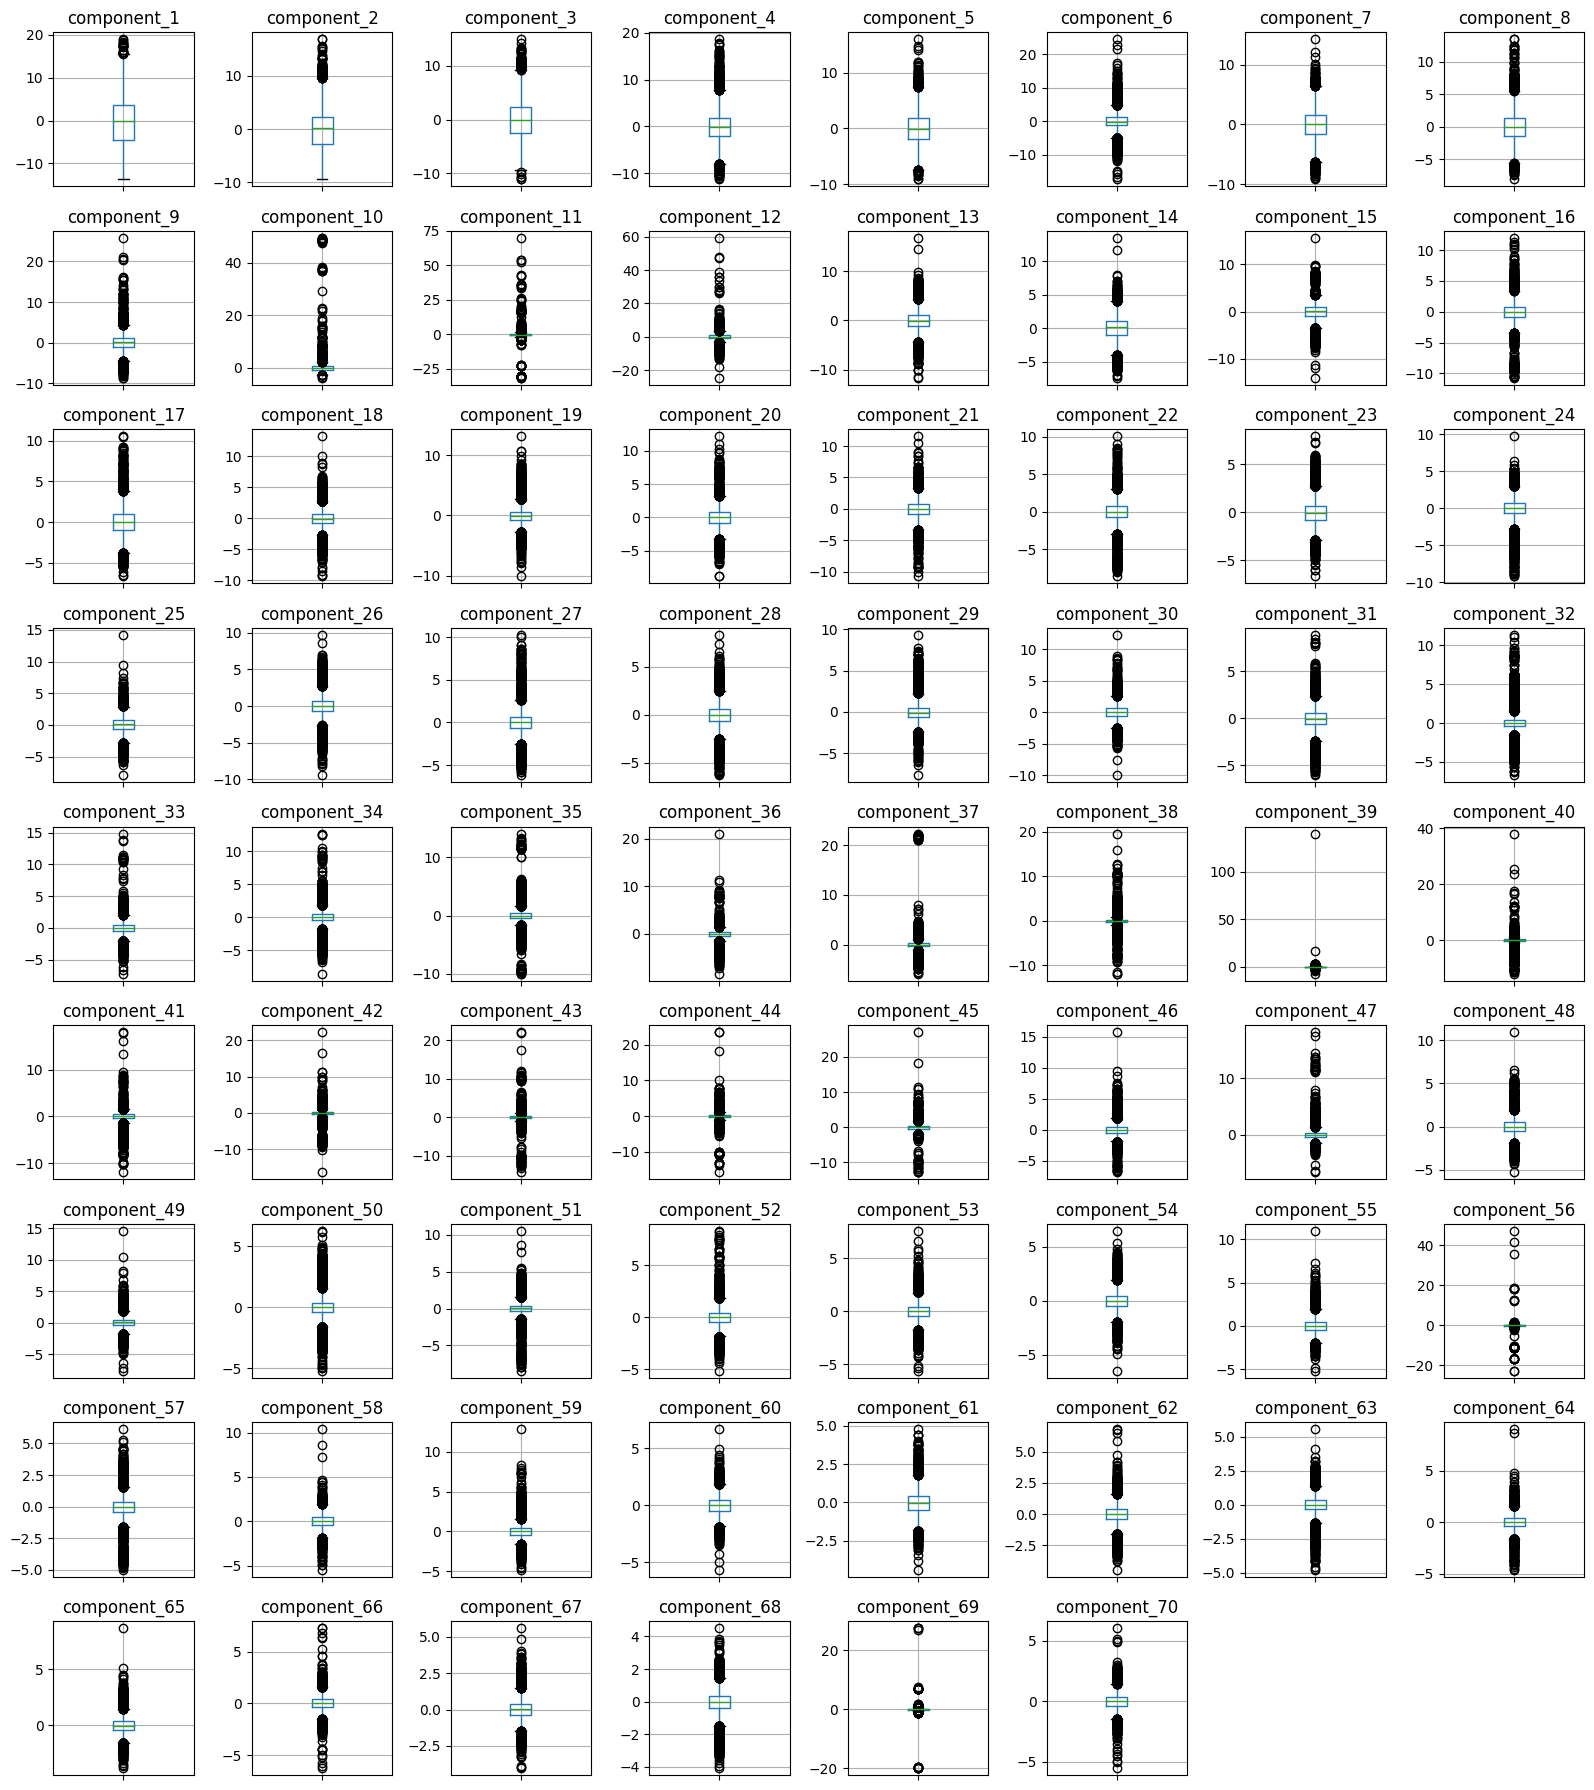

In [12]:
def boxplot(num_rows, num_cols, dataframe):
    num_subplots = len(dataframe.columns)

    num_blank_subplots = (num_rows * num_cols) - num_subplots

    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (16, 18))

    axes = np.array(axes).flatten()

    for i, column in enumerate(dataframe.columns):
        ax = axes[i]
        dataframe.boxplot(column = column, ax = ax)
        ax.set_title(column)  
        ax.set_xticklabels([])  

    for j in range(num_subplots, num_rows * num_cols):
        axes[j].axis('off')
    plt.tight_layout()
    return plt.show()

boxplot(9, 8, df_x_pca)

From the graphs above, it can be seen that almost every column is affected by the presence of outliers. The next step is to calculate the number the actual number of outliers per column. This is accomplished using the 1.5 times the Interquartile Range (IQR) method, where data points exceeding 1.5 times the IQR above the 75th percentile and below the 25th percentile are identified as outliers. 

In [13]:
def outlier (dataframe):
    for x in dataframe.columns:
        first = dataframe[x].quantile(0.25)
        third = dataframe[x].quantile(0.75)

        IQR = third - first
        lower_bound = first - 1.5*IQR
        upper_bound = third + 1.5*IQR

        dataframe[f'outlier_{x}'] = dataframe[x].apply(lambda value: 1 if (value >= upper_bound) | (value <= lower_bound) else 0)

    start_index = next(dataframe.columns.get_loc(x) for x in dataframe.columns if x.startswith('outlier'))
    original_df, outlier_df = dataframe.iloc[:,:start_index], dataframe.iloc[:,start_index:]
    original_df['total'] = outlier_df.sum(axis = 1)
    return original_df 

x_df = outlier(df_x_pca)
display(x_df)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70,total
0,5.422019,-1.393346,13.266361,17.861929,14.198995,21.410747,-0.024813,5.291344,-0.933015,-2.298932,...,-0.991981,1.862571,2.967464,0.961460,-0.751658,1.337947,-0.804344,0.048684,-1.113154,11
1,9.374021,4.906049,9.654574,15.197851,14.881054,24.499612,-1.435542,7.558944,1.188192,-3.369884,...,-2.060213,5.537235,9.055971,-2.575572,5.281524,1.226415,-0.443087,-1.039402,-0.622297,25
2,10.172213,5.528628,9.689506,16.398643,16.090855,22.661743,1.265243,7.540092,1.740296,-3.829621,...,-1.832647,4.109393,8.746102,-3.783771,4.620716,1.062939,-0.464021,-0.741863,-0.257440,22
3,9.830465,2.787265,15.012905,18.649968,11.300852,14.333539,0.079719,2.964232,2.252977,-1.111759,...,-0.050686,0.398781,1.261512,-0.109377,0.258524,0.853064,1.250901,-0.064026,-0.284956,7
4,12.996386,3.242484,13.333088,17.298744,11.700945,12.873008,0.850233,6.142462,-2.831243,-1.004740,...,-0.067154,-0.248231,0.844383,-2.622156,-1.447949,2.116390,0.065457,0.967035,-1.369522,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21781,2.615890,-1.498775,-2.128677,1.784871,-2.736303,-4.102645,4.669474,3.331067,-4.536531,6.494771,...,1.042026,0.582900,0.858161,0.886876,-1.234991,0.000327,-0.646479,0.272838,0.509199,12
21782,-1.342530,-1.533144,0.140333,2.996040,-4.851216,-4.628742,4.963769,7.159419,-2.513171,5.237163,...,0.572655,0.634949,0.351898,1.215270,-0.146389,0.444436,-0.689464,0.174927,0.734801,14
21783,2.585728,-1.066882,-2.758877,0.951525,-3.298904,-3.472460,3.102636,4.606340,-2.702175,5.845364,...,-0.245964,0.033505,0.331664,1.144454,0.052447,-0.604086,-0.572088,0.015686,-0.087068,12
21784,2.752418,-1.675327,-2.825271,2.155355,-1.874370,-5.156593,6.414746,5.175410,-2.212541,5.705970,...,0.835999,0.431378,0.257020,0.664566,0.059083,-0.016718,-0.216935,0.160490,-0.246714,12


In this section, I go through each column of the dataset, calculating important metrics such as the first and third quartiles, as well as the interquartile range. Based on these values, I determine lower and upper bounds for identifying outliers. For each column, I add a new column to the dataset indicating whether a value is an outlier (marked as 1) or not (marked as 0). Subsequently, I split the extended dataframe into two parts: the original feature dataframe and a new dataframe containing only the outlier columns. By summing up these outlier columns, I derive the total outliers present in each row, which I add to the features dataframe.

In [14]:
num_outlier = x_df.groupby('total').count()
display(num_outlier)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70
total,,,,,,,,,,,,,,,,,,,,,
0,8539,8539,8539,8539,8539,8539,8539,8539,8539,8539,...,8539,8539,8539,8539,8539,8539,8539,8539,8539,8539
1,3778,3778,3778,3778,3778,3778,3778,3778,3778,3778,...,3778,3778,3778,3778,3778,3778,3778,3778,3778,3778
2,2269,2269,2269,2269,2269,2269,2269,2269,2269,2269,...,2269,2269,2269,2269,2269,2269,2269,2269,2269,2269
3,1509,1509,1509,1509,1509,1509,1509,1509,1509,1509,...,1509,1509,1509,1509,1509,1509,1509,1509,1509,1509
4,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041
5,617,617,617,617,617,617,617,617,617,617,...,617,617,617,617,617,617,617,617,617,617
6,530,530,530,530,530,530,530,530,530,530,...,530,530,530,530,530,530,530,530,530,530
7,499,499,499,499,499,499,499,499,499,499,...,499,499,499,499,499,499,499,499,499,499
8,450,450,450,450,450,450,450,450,450,450,...,450,450,450,450,450,450,450,450,450,450


From the result above, it is seen that most of the rows have up 10 outliers with a few rows having up to 52 outliers. From analysis, it is noted that 95% of the dataset has less than 13 outliers, so only those rows will be kept.

In [15]:
big_df = pd.concat([x_df, df_y], axis = 1)
final = big_df[big_df['total'] < 13].drop('total', axis = 1).reset_index(drop = True)
x, y = final.iloc[:,:-12], final.iloc[:,-12:]
display(x), display(y)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70
0,5.422019,-1.393346,13.266361,17.861929,14.198995,21.410747,-0.024813,5.291344,-0.933015,-2.298932,...,3.904986,-0.991981,1.862571,2.967464,0.961460,-0.751658,1.337947,-0.804344,0.048684,-1.113154
1,9.830465,2.787265,15.012905,18.649968,11.300852,14.333539,0.079719,2.964232,2.252977,-1.111759,...,-0.541838,-0.050686,0.398781,1.261512,-0.109377,0.258524,0.853064,1.250901,-0.064026,-0.284956
2,12.996386,3.242484,13.333088,17.298744,11.700945,12.873008,0.850233,6.142462,-2.831243,-1.004740,...,-0.081375,-0.067154,-0.248231,0.844383,-2.622156,-1.447949,2.116390,0.065457,0.967035,-1.369522
3,10.786440,0.197098,9.337265,17.511072,10.416528,15.738573,2.462300,5.068168,-0.732663,-1.487945,...,-0.947220,-0.025958,-0.001832,0.074637,-0.540994,-0.690331,0.623021,0.728736,0.201913,-0.574445
4,2.945315,-1.392845,12.558718,15.733495,10.647161,17.403655,0.992381,5.793198,-2.455049,-0.279908,...,2.387099,-0.888156,1.611498,1.341213,0.539336,-0.134819,0.538249,-0.011766,-0.194875,-0.020948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,-0.849029,-1.556124,0.507306,2.678223,-5.087181,-4.541207,4.982434,6.807930,-2.462277,4.725864,...,-0.055243,0.833079,0.828047,0.425792,0.730335,-0.605396,0.599314,-0.391672,0.297630,0.121927
20581,3.296103,-1.082148,-2.383180,0.463573,-3.296851,-3.309314,2.953523,4.091548,-2.955430,5.547727,...,-0.153514,0.525198,0.444710,-0.337902,0.627772,-0.384175,0.289293,0.053091,0.187023,-0.039905
20582,2.615890,-1.498775,-2.128677,1.784871,-2.736303,-4.102645,4.669474,3.331067,-4.536531,6.494771,...,0.314197,1.042026,0.582900,0.858161,0.886876,-1.234991,0.000327,-0.646479,0.272838,0.509199
20583,2.585728,-1.066882,-2.758877,0.951525,-3.298904,-3.472460,3.102636,4.606340,-2.702175,5.845364,...,0.066359,-0.245964,0.033505,0.331664,1.144454,0.052447,-0.604086,-0.572088,0.015686,-0.087068


,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,0.181502,0.409931,0.409939,0.1832,0.1832
1,0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000,0.244879,0.255051,0.0000,0.0000
2,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000,0.283425,0.296993,0.0000,0.0000
3,0.153914,0.291234,0.000000,0.091023,0.148553,0.312962,0.000000,0.157916,0.146839,0.304442,0.0000,0.0954
4,0.376138,0.376146,0.000000,0.000000,0.372867,0.372891,0.000000,0.000000,0.354965,0.354976,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
20580,0.325151,0.330777,0.015626,0.000749,0.329757,0.331850,0.006635,0.018367,0.317657,0.322799,0.0099,0.0008
20581,0.270820,0.298297,0.010386,0.022165,0.272629,0.306557,0.008115,0.040795,0.268020,0.298155,0.0099,0.0191
20582,0.271951,0.297488,0.049481,0.039746,0.279686,0.305949,0.045505,0.036458,0.276414,0.297798,0.0314,0.0409
20583,0.256356,0.279425,0.005103,0.010683,0.264920,0.280065,0.002531,0.009899,0.253210,0.279390,0.0037,0.0086


(None, None)

# Machine Learning

Now that we have successfully removed outliers from our dataset, we are well-prepared to delve into machine learning. Our features dataframe, comprising of 20,585 rows and 70 columns, encapsulates the essential characteristics of our data. Additionally, the label dataframe, with the same number of rows (20,585) but 12 columns, contains the corresponding target labels.

## Data Preparation

In [16]:
x, y = final.iloc[:,:-12], final.iloc[:,-12:]
display(x), display(y)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70
0,5.422019,-1.393346,13.266361,17.861929,14.198995,21.410747,-0.024813,5.291344,-0.933015,-2.298932,...,3.904986,-0.991981,1.862571,2.967464,0.961460,-0.751658,1.337947,-0.804344,0.048684,-1.113154
1,9.830465,2.787265,15.012905,18.649968,11.300852,14.333539,0.079719,2.964232,2.252977,-1.111759,...,-0.541838,-0.050686,0.398781,1.261512,-0.109377,0.258524,0.853064,1.250901,-0.064026,-0.284956
2,12.996386,3.242484,13.333088,17.298744,11.700945,12.873008,0.850233,6.142462,-2.831243,-1.004740,...,-0.081375,-0.067154,-0.248231,0.844383,-2.622156,-1.447949,2.116390,0.065457,0.967035,-1.369522
3,10.786440,0.197098,9.337265,17.511072,10.416528,15.738573,2.462300,5.068168,-0.732663,-1.487945,...,-0.947220,-0.025958,-0.001832,0.074637,-0.540994,-0.690331,0.623021,0.728736,0.201913,-0.574445
4,2.945315,-1.392845,12.558718,15.733495,10.647161,17.403655,0.992381,5.793198,-2.455049,-0.279908,...,2.387099,-0.888156,1.611498,1.341213,0.539336,-0.134819,0.538249,-0.011766,-0.194875,-0.020948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,-0.849029,-1.556124,0.507306,2.678223,-5.087181,-4.541207,4.982434,6.807930,-2.462277,4.725864,...,-0.055243,0.833079,0.828047,0.425792,0.730335,-0.605396,0.599314,-0.391672,0.297630,0.121927
20581,3.296103,-1.082148,-2.383180,0.463573,-3.296851,-3.309314,2.953523,4.091548,-2.955430,5.547727,...,-0.153514,0.525198,0.444710,-0.337902,0.627772,-0.384175,0.289293,0.053091,0.187023,-0.039905
20582,2.615890,-1.498775,-2.128677,1.784871,-2.736303,-4.102645,4.669474,3.331067,-4.536531,6.494771,...,0.314197,1.042026,0.582900,0.858161,0.886876,-1.234991,0.000327,-0.646479,0.272838,0.509199
20583,2.585728,-1.066882,-2.758877,0.951525,-3.298904,-3.472460,3.102636,4.606340,-2.702175,5.845364,...,0.066359,-0.245964,0.033505,0.331664,1.144454,0.052447,-0.604086,-0.572088,0.015686,-0.087068


,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,0.181502,0.409931,0.409939,0.1832,0.1832
1,0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000,0.244879,0.255051,0.0000,0.0000
2,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000,0.283425,0.296993,0.0000,0.0000
3,0.153914,0.291234,0.000000,0.091023,0.148553,0.312962,0.000000,0.157916,0.146839,0.304442,0.0000,0.0954
4,0.376138,0.376146,0.000000,0.000000,0.372867,0.372891,0.000000,0.000000,0.354965,0.354976,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
20580,0.325151,0.330777,0.015626,0.000749,0.329757,0.331850,0.006635,0.018367,0.317657,0.322799,0.0099,0.0008
20581,0.270820,0.298297,0.010386,0.022165,0.272629,0.306557,0.008115,0.040795,0.268020,0.298155,0.0099,0.0191
20582,0.271951,0.297488,0.049481,0.039746,0.279686,0.305949,0.045505,0.036458,0.276414,0.297798,0.0314,0.0409
20583,0.256356,0.279425,0.005103,0.010683,0.264920,0.280065,0.002531,0.009899,0.253210,0.279390,0.0037,0.0086


(None, None)

Before conducting machine learning, we have to check the data again. Since PCA was conducted, and the components are not analogous to the original features, the data has to be scaled again. This is done below.

In [17]:
standard = StandardScaler()
x_scale = standard.fit_transform(x)
display(pd.DataFrame(x_scale))

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,1.038857,-0.364736,4.003256,5.826642,5.319132,9.168923,-0.003430,2.476258,-0.507660,-1.410068,...,5.592354,-1.437226,2.689353,4.448371,1.465189,-1.193329,2.182353,-1.280701,0.098328,-1.834503
1,1.839666,0.791530,4.532016,6.083859,4.226098,6.140838,0.043157,1.388700,1.182438,-0.651404,...,-0.781466,-0.053541,0.574573,1.896001,-0.167390,0.403885,1.397891,2.028804,-0.146461,-0.472408
2,2.414767,0.917433,4.023457,5.642818,4.376993,5.515929,0.386551,2.874021,-1.514627,-0.583014,...,-0.121466,-0.077750,-0.360185,1.271912,-3.998327,-2.294246,3.441747,0.119915,2.092860,-2.256139
3,2.013322,0.075146,2.813735,5.712122,3.892576,6.742002,1.104999,2.371958,-0.401377,-0.891806,...,-1.362518,-0.017192,-0.004205,0.120251,-0.825426,-1.096364,1.025720,1.187976,0.431120,-0.948516
4,0.588955,-0.364598,3.789020,5.131917,3.979559,7.454431,0.449902,2.710795,-1.315065,-0.119810,...,3.416702,-1.284605,2.326620,2.015247,0.821626,-0.218036,0.888572,-0.004435,-0.430649,-0.038208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,-0.100300,-0.409757,0.140494,0.870653,-1.954645,-1.934992,2.228145,3.185022,-1.318899,3.079132,...,-0.084009,1.245574,1.194745,0.645634,1.112819,-0.962072,0.987366,-0.616187,0.639006,0.196771
20581,0.652677,-0.278665,-0.734591,0.147788,-1.279422,-1.407909,1.323923,1.915542,-1.580506,3.604344,...,-0.224865,0.792996,0.640927,-0.496971,0.956454,-0.612297,0.485802,0.100004,0.398781,-0.069385
20582,0.529114,-0.393895,-0.657541,0.579062,-1.068012,-1.747347,2.088669,1.560138,-2.419244,4.209553,...,0.445525,1.552722,0.840574,1.292525,1.351479,-1.957535,0.018302,-1.026495,0.585161,0.833699
20583,0.523635,-0.274443,-0.848332,0.307056,-1.280197,-1.477713,1.390377,2.156126,-1.446160,3.794548,...,0.090288,-0.340596,0.046848,0.504803,1.744178,0.078053,-0.959538,-0.906705,0.026662,-0.146952


We then split that data into train and test data for features and labels. The model will train on the training data features and labels and will predict the test data labels from the test data features. This predictions will be compared to the true test data labels and the error between them is defined as the loss. The goal of the model is to minimize this loss to improve performance. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, test_size = 0.2, random_state = 19)

print(f'Train features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}') 
print(f'Train labels shape: {y_train.shape}')
print(f'Test labels shape: {y_test.shape}')

Train features shape: (16468, 70)
Test features shape: (4117, 70)
Train labels shape: (16468, 12)
Test labels shape: (4117, 12)


In this scenario, 20% of the dataset is set aside as a test set, while the remaining 80% constitutes the training set. This division is a commonly employed practice in various problems. The random state parameter is used to ensure consistent splitting, ensuring reproducibility of results.

## Support Vector Machines

In the next phase, machine learning will be performed using support vector machines, a model which is normally used for classification purposes, where the goal is to denote a decision boundary between the classes. It defines two linear 'support vectors' around the boundary and aims to maximize the size of the margin. This model can also be applied to regression problems, which is known as support vector regression (SVR) where the goal is to find a hyperplane which minimizes the distance between the data points and the hyperplane, while also maximizing the margin between the data points and the hyperplane [Choudhary, 2023](https://medium.com/@dhirendrachoudhary_96193/why-support-vector-regression-difference-between-svr-and-a-simple-regression-model-8cd752a77bbc). The support vectors in this case is the tolerance around the decision boundary where the datapoints are allowed to exist, with points outside this margin being included in loss calculations. 

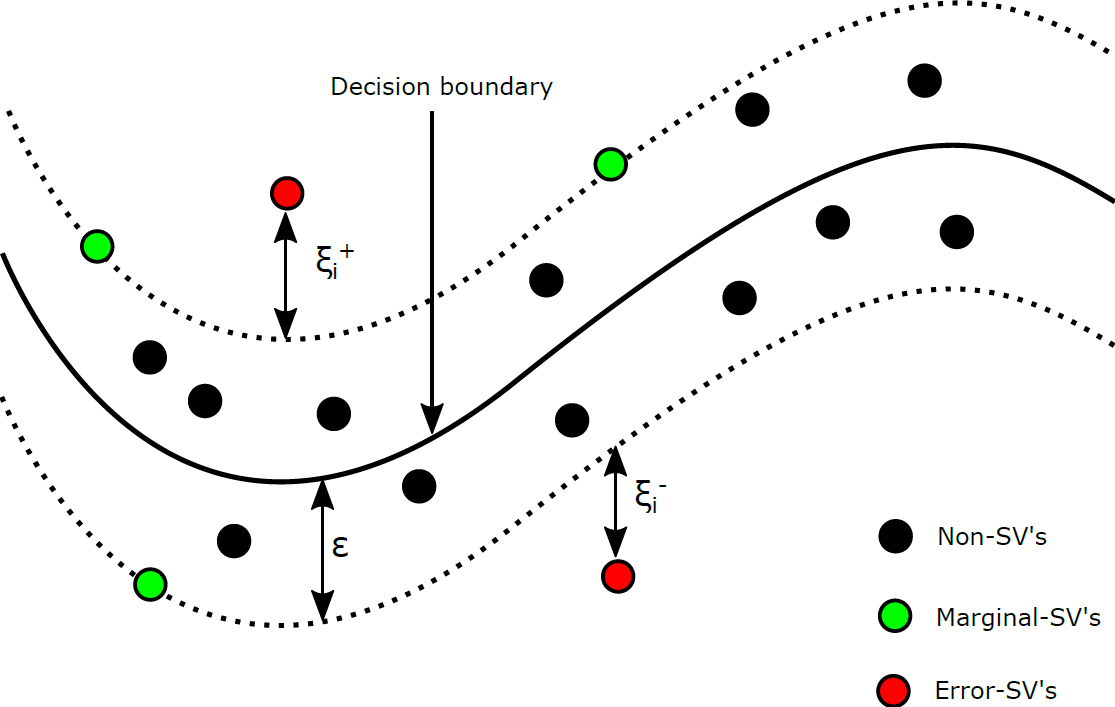

[Singh, 2020](https://medium.com/analytics-vidhya/support-vector-regression-svr-model-a-regression-based-machine-learning-approach-f4641670c5bb)

### Baseline Comparison

In [19]:
def baseline(x_train, x_test, y_train, y_test):
    model = MultiOutputRegressor(SVR(C = 1, epsilon = 0.1))
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE

MAE = baseline(X_train, X_test, y_train, y_test)
print(f'The MAE on the test dataset is {MAE:1.4f}.')

The MAE on the test dataset is 0.0431.


In the evaluation of the QM8 dataset, the use of Support Vector Regression (SVR) poses a challenge due to its inherent limitation for binary problems. To address this limitation, the SVR class is wrapped with the MultiOutputRegressor class, which instantiates 12 different SVR models, corresponding to the 12 labels. The models are then trained individually. During prediction, the outputs of all 12 labels are concatenated together, allowing for MAE to be calculated. The MAE obtained is a uniform average across all the labels. 

### Cross-Validation

Although the Mean Absolute Error (MAE) mentioned above might seem low at first glance, it's important to note that it significantly trails behind the performance achieved by state-of-the-art models. Additionally, the model has a high chance of overfitting, adversely impacting its ability to generalize to new data. To address this, K-fold cross validation was carried out where a small subset of the train data is set aside for the model to validate and this validation set alternates K times.

In [20]:
model = MultiOutputRegressor(SVR(C = 1, epsilon = 0.1))

cvv = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'neg_mean_absolute_error')
print(f'The MAE for each fold is {-cvv}.')
print('\n')
print(f'The MAE after 3-fold cross validation is {-cvv.mean():1.4f}.')

The MAE for each fold is [0.04399379 0.044538   0.04427928].


The MAE after 3-fold cross validation is 0.0443.


For this problem, 3-fold cross validation was conducted. For each fold, 12 different models were instantiated and fitted to the 12 labels, where the MAE is calculated and averaged to obtain the fold MAE. The final MAE across all the folds was calculated to be 0.0443.

### Hyperparameter Tuning

With the model still performing poorly even after cross-validation, one option to improve the performance is through hyperparameter tuning. There are two important hyperparameters which heavily impact the performance of the SVR.

$\textbf{epsilon}$: The Epsilon parameter is the size of the tube around the hyperplane where most of the points lie on. Any points in this tube is considered as a correct prediction. A smaller epsilon value indicates a better fit but runs the risk of overfitting while a larger value makes the model more robust in exchange for a slightly poorer fit.

$C$: The C parameter is the regularization parameter which controls the margin of epsilon. A smaller C value creates a fit which has less points outside the epsilon margin, which is better but runs the risk of overfitting while a larger C value relaxes the margin allowing for more points outside the epsilon margin, which increases the generalizability of the model.

In [21]:
svr_param_grid = {'estimator__C': [1, 10, 100],  
              'estimator__epsilon': [1, 0.1, 0.01]}

svr_tuning = GridSearchCV(estimator = model, param_grid = svr_param_grid, 
                         cv = 3, scoring = 'neg_mean_absolute_error', verbose = 3)
svr_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END estimator__C=1, estimator__epsilon=1;, score=-0.147 total time=   0.0s
[CV 2/3] END estimator__C=1, estimator__epsilon=1;, score=-0.140 total time=   0.1s
[CV 3/3] END estimator__C=1, estimator__epsilon=1;, score=-0.150 total time=   0.0s
[CV 1/3] END estimator__C=1, estimator__epsilon=0.1;, score=-0.044 total time=   8.5s
[CV 2/3] END estimator__C=1, estimator__epsilon=0.1;, score=-0.045 total time=   8.7s
[CV 3/3] END estimator__C=1, estimator__epsilon=0.1;, score=-0.044 total time=   8.8s
[CV 1/3] END estimator__C=1, estimator__epsilon=0.01;, score=-0.016 total time= 2.2min
[CV 2/3] END estimator__C=1, estimator__epsilon=0.01;, score=-0.016 total time= 3.1min
[CV 3/3] END estimator__C=1, estimator__epsilon=0.01;, score=-0.016 total time= 3.7min
[CV 1/3] END estimator__C=10, estimator__epsilon=1;, score=-0.147 total time=   0.2s
[CV 2/3] END estimator__C=10, estimator__epsilon=1;, score=-0.140 total time=   0.1s

GridSearchCV(cv=3, estimator=MultiOutputRegressor(estimator=SVR(C=1)),
             param_grid={'estimator__C': [1, 10, 100],
                         'estimator__epsilon': [1, 0.1, 0.01]},
             scoring='neg_mean_absolute_error', verbose=3)

Sklearn's GridSearchCV was used to conduct hyperparameter tuning. The number of folds was kept at 3 and the metric used was mean absolute error. 

In [22]:
best = svr_tuning.best_params_

print(f'The hyperparameter combination which gives the best performance is \
C = {best["estimator__C"]} and epsilon = {best["estimator__epsilon"]}, with a score of {-svr_tuning.best_score_:1.4f}.')

The hyperparameter combination which gives the best performance is C = 1 and epsilon = 0.01, with a score of 0.0158.


Following this, the MAE of the tuned model on the test dataset is given below.

In [23]:
best_y_pred = svr_tuning.predict(X_test)
best_MAE = mean_absolute_error(y_test, best_y_pred)

print(f'The MAE of the tuned model on the test dataset is {best_MAE:1.4f}.')

The MAE of the tuned model on the test dataset is 0.0148.


### MAE comparison across models

Given the final MAE value for the QM8 dataset when using Support Vector Regressor, the next step involves comparing it with other models. Four specific models were chosen, a combination of graphical neural networks (D-MPNN, MOLCLR) and transformers (Uni-Mol, 3D Graph Contrastive Learning) [Results Table](https://watermark.silverchair.com/btad371.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3IwggNuBgkqhkiG9w0BBwagggNfMIIDWwIBADCCA1QGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMB_jAFKRJKkguwboOAgEQgIIDJRK4NTqD0toaxvjUf-ctMGi-pWB5Ow2kyHrqy9PST2r9H41Ov-O1zeRUrxFZ1TIJQg1sMHK5xRfF6MiI93C-k_RVg8tCPi9I0If-n6L7tr_NMXk_Q4rdeuFbICX5RvgPhea92AgcLNGxc8jPq5HQGf-m7lzvzHxjcJJEOV-ffoZjkBKsyd1-tA8UTpsOQRvixIiH0EeJ62P_JrVWkxGITP2tuJhU6-qHTCL8f_kRR40I-yO_r2L7_Y_7inE7qy50xwCQkHU9BzFd5Xix7QobLOUpX_0TpmlQrczocGdaybJGy3iM7q6i41N0ilV8Hz6de4_ASHIq6J_AfLfXHup3sfEP4is7CSFO7EdecFk6CkQNCbVEOCmtdys2zhkPRA6_qBDW6YzXVcaGqSf8l2Jnaqoh1f5_N_uknPvAHtNZXWGQm1GVh1ZOWtfLe13Co9x0kpRMlblXIQQjtLOPAh665pFrTFUfLlF0Cy8UULgKyjjqMF_SbOIs3dnUE9kA5DWWkJB9uOsL2nfeG0tbw8uk2NewTkGVEndazEN3i5E2olEbm-tbgeo51G8EkcBrkbWaNOk1x0_Sy50gY3BS98EO5ewb2dqmnYA-pkpEIax-305kbCZx0OXQQWhi-MJ2C3IxwnIuK0GrbAFEs9E9X7YGKUvPKE8LPhwVTZ4ycxgGuQwYTwt2XbJjZeFVeWYiz7coxtK2dG29XOIYw2S9xkp_IfofSAR0QbqoxRUtkSAXNZyeP2sExi8kji6D5Owh7n1U4VJtaLRJwMkdlsq_0reneA1G7WFZMZz-SWI3ufuBKM8WGCTr-LeA57Xr7XyCGCMJaAtydyQPaE_ZOC-CfU7q7OUDyzzqxtvkS-SjO9tghG0KB3T3NFh7E_DCDS5BSmH5nF9J41hI2AuJtqFoH8chGhnVbqEJVO7NYrrNe_FPMeDU8SFIrI75wPdzT7QMCuWeXRVNPAuB9EohYmDYCxp8OPBLgEmXX2oIYH2ztpGBO1EN39KiMM1AromUyiLoljMGMN9q_tyo5CqzA7mFqBowk9TaiRQ5J7-bTBLO2ZHeY3HZVeYslAI). The MAE comparison for QM8 for the models are shown below.

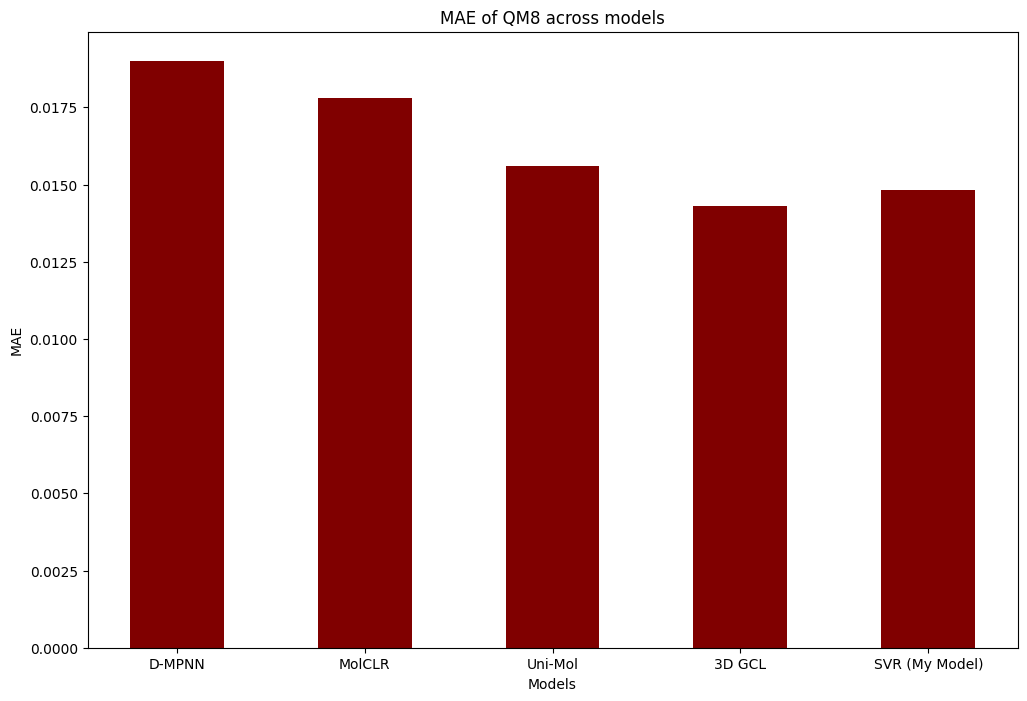

In [24]:
array = [0.0190, 0.0178, 0.0156, 0.0143, best_MAE]
x = ['D-MPNN', 'MolCLR', 'Uni-Mol', '3D GCL', 'SVR (My Model)']

plt.figure(figsize = (12, 8))
plt.bar(x, array, width = 0.5, color = 'maroon')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAE of QM8 across models');

Given the comparison, it is noted that a properly tuned Support Vector Regression performs comparably to Uni-Mol [Uni-Mol](https://openreview.net/pdf?id=6K2RM6wVqKu), which is noteworthy as Uni-Mol comprises of two transformer models pretrained on molecular conformers. It is able to outperform graphical networks employing pretraining strategies like D-MPNN [D-MPNN](https://dspace.mit.edu/bitstream/handle/1721.1/123133/1128814048%E2%80%90MIT.pdf?sequence=1&isAllowed=y) and MolCLR [MolCLR](https://www.nature.com/articles/s42256-022-00447-x) while falling behind 3D Graph Contrastive Learning (3D-GCL) [3d-GCL](https://watermark.silverchair.com/btad371.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3IwggNuBgkqhkiG9w0BBwagggNfMIIDWwIBADCCA1QGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMB_jAFKRJKkguwboOAgEQgIIDJRK4NTqD0toaxvjUf-ctMGi-pWB5Ow2kyHrqy9PST2r9H41Ov-O1zeRUrxFZ1TIJQg1sMHK5xRfF6MiI93C-k_RVg8tCPi9I0If-n6L7tr_NMXk_Q4rdeuFbICX5RvgPhea92AgcLNGxc8jPq5HQGf-m7lzvzHxjcJJEOV-ffoZjkBKsyd1-tA8UTpsOQRvixIiH0EeJ62P_JrVWkxGITP2tuJhU6-qHTCL8f_kRR40I-yO_r2L7_Y_7inE7qy50xwCQkHU9BzFd5Xix7QobLOUpX_0TpmlQrczocGdaybJGy3iM7q6i41N0ilV8Hz6de4_ASHIq6J_AfLfXHup3sfEP4is7CSFO7EdecFk6CkQNCbVEOCmtdys2zhkPRA6_qBDW6YzXVcaGqSf8l2Jnaqoh1f5_N_uknPvAHtNZXWGQm1GVh1ZOWtfLe13Co9x0kpRMlblXIQQjtLOPAh665pFrTFUfLlF0Cy8UULgKyjjqMF_SbOIs3dnUE9kA5DWWkJB9uOsL2nfeG0tbw8uk2NewTkGVEndazEN3i5E2olEbm-tbgeo51G8EkcBrkbWaNOk1x0_Sy50gY3BS98EO5ewb2dqmnYA-pkpEIax-305kbCZx0OXQQWhi-MJ2C3IxwnIuK0GrbAFEs9E9X7YGKUvPKE8LPhwVTZ4ycxgGuQwYTwt2XbJjZeFVeWYiz7coxtK2dG29XOIYw2S9xkp_IfofSAR0QbqoxRUtkSAXNZyeP2sExi8kji6D5Owh7n1U4VJtaLRJwMkdlsq_0reneA1G7WFZMZz-SWI3ufuBKM8WGCTr-LeA57Xr7XyCGCMJaAtydyQPaE_ZOC-CfU7q7OUDyzzqxtvkS-SjO9tghG0KB3T3NFh7E_DCDS5BSmH5nF9J41hI2AuJtqFoH8chGhnVbqEJVO7NYrrNe_FPMeDU8SFIrI75wPdzT7QMCuWeXRVNPAuB9EohYmDYCxp8OPBLgEmXX2oIYH2ztpGBO1EN39KiMM1AromUyiLoljMGMN9q_tyo5CqzA7mFqBowk9TaiRQ5J7-bTBLO2ZHeY3HZVeYslAI), which conducts contrastive learning with the 3D geometry of the molecules. From here, it is observed that a properly tuned SVM can perform very well in molecular property prediction tasks in particular. However, models like Uni-Mol and 3D GCL exhibit versatility by excelling not only in predictive tasks but also in generative tasks, making them more versatile and adaptable for a range of applications.

# Conclusion

In conclusion, machine learning has significant applications in the field of cheminfomatics, especially in the field of molecular property prediction. In this project, fingerprint vectors were generated from the SMILES present in the QM8 dataset, and prepared through various data preprocessing steps such as standardization, principal component analysis and outlier analysis. As a multi-output regression problem, support vector regressors were fitted to every label present and the MAE was averaged across all 12 labels. K-Fold cross validation and hyperparameter tuning was carried out and the final MAE on the test dataset was reported. While this displays good performance, this could be improved through using more complex models such as graphical neural networks and transformers. 